In [1]:
import pandas as pd
import warnings 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

## 파일 불러오기

In [2]:
data = pd.read_csv('data/final_data.csv').drop(['기온'], axis=1)

In [3]:
data

,시간대,성별,연령대,지역,기분,1순위,2순위,3순위,강수량,습도,...,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕,날짜,시간,요일
0,2021-05-16 14:00:00,남자,청년,수도권,행복,한식,일식,중식,1.6,99.1,...,2,0,0,2,0,0,1,05-16,14,일
1,2021-05-16 15:00:00,여자,중장년,서울,분노,한식,중식,일식,1.4,97.0,...,0,0,1,0,2,0,0,05-16,15,일
2,2021-05-16 15:00:00,남자,청년,서울,중립,일식,양식,한식,1.4,97.0,...,0,0,3,3,0,0,0,05-16,15,일
3,2021-05-16 15:00:00,여자,청년,서울,행복,일식,한식,분식,1.4,97.0,...,3,0,0,0,0,0,0,05-16,15,일
4,2021-05-16 16:00:00,남자,청년,경상도,행복,양식,일식,분식,2.6,94.7,...,2,0,0,2,0,0,0,05-16,16,일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2021-05-24 16:00:00,남자,노년,경상도,행복,한식,분식,중식,0.0,52.2,...,0,0,0,0,0,0,1,05-24,16,월
417,2021-05-24 16:00:00,남자,노년,수도권,행복,한식,일식,중식,0.0,45.1,...,0,0,2,0,0,1,0,05-24,16,월
418,2021-05-24 16:00:00,여자,노년,전라도,행복,한식,중식,일식,0.0,57.0,...,0,0,0,1,2,0,0,05-24,16,월
419,2021-05-24 16:00:00,남자,노년,전라도,우울,분식,양식,일식,0.0,57.0,...,0,0,1,0,0,0,0,05-24,16,월


## 컬럼 설정

In [4]:
# 평일 / 주말 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "요일"] == "일":
        data.loc[i, "휴일"] = "주말"
    else:
        data.loc[i, "휴일"] = "평일"

In [5]:
# 비 / 비안옴 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "강수량"] == 0:
        data.loc[i, "비"] = "비안옴"
    else:
        data.loc[i, "비"] ="비옴"

In [6]:
# 전운량 구분 컬럼 생성

data.loc[(data['전운량']>=0) & (data['전운량']<=5), '구름'] = "맑음"
data.loc[(data['전운량']>=6) & (data['전운량']<=8), '구름'] = "구름많음"
data.loc[(data['전운량']>=9) & (data['전운량']<=10), '구름'] = "흐림"

In [7]:
# 식사시간 구분 컬럼 생성

for i in range(len(data)):
    if data.loc[i, "시간"]>=16 and data.loc[i, "시간"]<=23:
        data.loc[i, "식사시간"] = "저녁"
    elif data.loc[i, "시간"]>=11 and data.loc[i, "시간"]<16:
        data.loc[i, "식사시간"] = '점심'
    else:
        data.loc[i, "식사시간"] = "아침"

# 분석

In [8]:
# 상관계수 확인

data.corr()

,강수량,습도,기압,전운량,불고기,냉면,칼국수,된장찌개,비빔밥,김치찌개,...,스테이크,햄버거,초밥,우동,메밀소바,돈가스,볶음밥,짜장면,짬뽕,시간
강수량,1.000000,0.646806,-0.700074,0.664715,0.001841,0.045296,0.129529,0.052960,0.063549,0.114980,...,0.188369,0.077200,-0.007127,0.066115,0.001464,0.066573,-0.000945,0.071957,0.116386,0.367359
습도,0.646806,1.000000,-0.397219,0.832120,0.003368,-0.020772,0.089629,0.070824,0.066317,0.125959,...,0.186695,0.110976,0.075729,0.111340,0.064341,0.117401,-0.027462,0.141485,0.063441,0.139990
기압,-0.700074,-0.397219,1.000000,-0.582468,0.028341,-0.000725,-0.037571,-0.000374,0.000924,-0.099495,...,-0.108811,-0.052877,0.064191,-0.030581,0.013056,0.024343,-0.046817,-0.105452,-0.180310,-0.418967
전운량,0.664715,0.832120,-0.582468,1.000000,-0.026188,-0.050169,0.055364,0.133753,0.007479,0.116974,...,0.122339,0.114186,0.055357,0.052953,0.031805,0.091980,0.018417,0.136597,0.080176,0.128252
불고기,0.001841,0.003368,0.028341,-0.026188,1.000000,0.144565,0.041496,0.054306,0.028985,0.070974,...,0.026404,0.051709,-0.001934,0.051623,-0.030632,0.028400,0.041174,0.010057,-0.096606,0.012085
냉면,0.045296,-0.020772,-0.000725,-0.050169,0.144565,1.000000,0.233113,0.071291,0.010261,0.100727,...,0.006052,0.025026,0.106389,0.051719,0.216055,0.006288,-0.080071,-0.060032,-0.066712,0.021120
칼국수,0.129529,0.089629,-0.037571,0.055364,0.041496,0.233113,1.000000,0.072767,0.120980,0.098153,...,0.043060,0.002461,0.048350,0.161043,0.110129,0.051587,-0.031574,-0.072844,-0.035171,0.001691
된장찌개,0.052960,0.070824,-0.000374,0.133753,0.054306,0.071291,0.072767,1.000000,0.048006,0.100960,...,0.027055,-0.053404,0.015352,0.142923,-0.037882,-0.036601,0.005448,-0.073512,-0.032777,-0.049114
비빔밥,0.063549,0.066317,0.000924,0.007479,0.028985,0.010261,0.120980,0.048006,1.000000,-0.000343,...,-0.030202,-0.093167,-0.001635,0.038992,0.036881,-0.025668,-0.041188,-0.037729,-0.064594,0.023361
김치찌개,0.114980,0.125959,-0.099495,0.116974,0.070974,0.100727,0.098153,0.100960,-0.000343,1.000000,...,-0.040497,0.043769,0.021576,0.063169,-0.017586,0.055798,0.036961,0.001255,0.079869,0.074653


# K-medoids 모델링

In [9]:
# 파일 복사

df = data.copy()

In [10]:
total = df.loc[:,["성별", "연령대", "기분", "구름", "휴일", "식사시간", "비"]]

In [11]:
# 데이터 더미화

df_dummy = pd.get_dummies(total)

In [12]:
# 데이터 표준화

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df_dummy))
data_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,-0.332893,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040


In [13]:
kmedoids_data = data_scaled.copy()

### Elbow Method

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with 

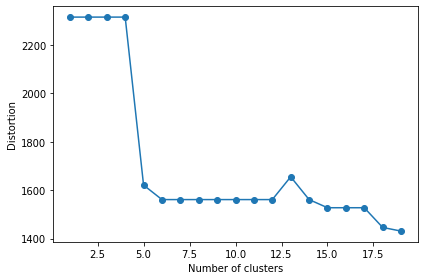

In [14]:
dist =[]
for i in range(1,20):
    k = KMedoids(n_clusters=i, random_state=0)
    k.fit(kmedoids_data)
    dist.append(k.inertia_)

plt.plot(range(1,20),dist, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [15]:
np.random.seed(123)

total_sd_arr = kmedoids_data.values

# k값을 5로 설정 후, k-means에 적용시키기
kmedoids = KMedoids(n_clusters=5, random_state=2021).fit(total_sd_arr)
kmedoids.cluster_centers_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(


array([[ 0.83931725, -0.83931725, -0.36711155, -0.5214435 , -0.80683356,
         1.6312172 , -0.21740212, -0.48061851, -0.63876972,  1.04619662,
        -0.33289329, -0.88965688,  1.08689795,  1.4091897 , -1.4091897 ,
        -0.375395  ,  0.91565711, -0.70584746, -1.16273613,  1.16273613],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851,  1.5655094 , -0.95584327,
        -0.33289329,  1.12402885, -0.92004958, -0.70962767,  0.70962767,
        -0.375395  , -1.09211187,  1.41673669,  0.86004036, -0.86004036],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851, -0.63876972,  1.04619662,
        -0.33289329,  1.12402885, -0.92004958, -0.70962767,  0.70962767,
        -0.375395  ,  0.91565711, -0.70584746,  0.86004036, -0.86004036],
       [ 0.83931725, -0.83931725, -0.36711155, -0.5214435 ,  1.239413  ,
        -0.61303915, -0.21740212, -0.48061851, -

In [16]:
# 군집 labels 컬럼 추가

kmedoids_data['cluster'] = kmedoids.labels_
kmedoids_data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,cluster
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,1
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,2


### t-SNE

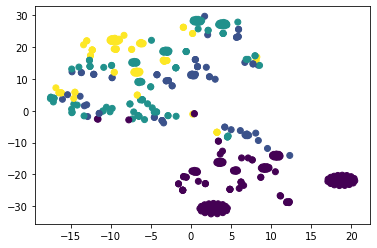

In [17]:
# t-SNE 시각화

model = TSNE(learning_rate=100)
transformed = model.fit_transform(kmedoids_data.iloc[:,:20])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmedoids.labels_)

plt.show()

# K-means 모델링

In [18]:
# 데이터 복제

kmeans_data = data_scaled.copy()

### Elbow Method

In [19]:
def elbow(X):
    sse = []

    for i in range(1,20):
        km = KMeans(n_clusters=i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,20), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

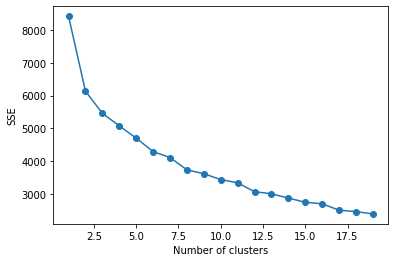

In [20]:
elbow(kmeans_data)

In [21]:
# 군집 개수 설정

kmeans = KMeans(n_clusters=5,
                random_state=200,
                init='k-means++',
                n_init=10,
                max_iter=300).fit(kmeans_data)

In [22]:
# 군집 labels 컬럼 추가

kmeans_data['cluster'] = kmeans.labels_
kmeans_data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,cluster
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
3,-1.191445,1.191445,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0
4,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,-0.889657,1.086898,1.409190,-1.409190,-0.375395,0.915657,-0.705847,-1.162736,1.162736,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
417,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
418,-1.191445,1.191445,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3
419,0.839317,-0.839317,2.723968,-0.521443,-0.806834,-0.613039,-0.217402,2.080652,-0.638770,-0.955843,...,1.124029,-0.920050,-0.709628,0.709628,-0.375395,0.915657,-0.705847,0.860040,-0.860040,3


### Silhouette Method

In [23]:
%matplotlib inline

#추가 라벨이 붙지않는 오리지널 데이터(silhuette_data는 cluster나 silhouette_coeff같은 새 컬럼이 추가 될 예정)
origin_data = kmeans_data.copy()

kmeans_data['cluster'] = kmeans.labels_

# 모든 개별 데이터에 실루엣 계수값을 구함
score_samples = silhouette_samples(origin_data, kmeans_data['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# data 실루엣 계수 컬럼 추가
kmeans_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함
average_score = silhouette_score(origin_data, kmeans_data['cluster'])
print('데이터셋 Silhouette Analysis Score:'.format(average_score))
print(average_score)

kmeans_data.head(3)

silhouette_samples( ) return 값의 shape (421,)
데이터셋 Silhouette Analysis Score:
0.26164064768534573


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,cluster,silhouette_coeff
0,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,-0.638770,1.046197,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.134848
1,-1.191445,1.191445,-0.367112,1.917753,-0.806834,-0.613039,4.599771,-0.480619,-0.638770,-0.955843,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.045583
2,0.839317,-0.839317,-0.367112,-0.521443,1.239413,-0.613039,-0.217402,-0.480619,1.565509,-0.955843,...,1.086898,1.40919,-1.40919,-0.375395,-1.092112,1.416737,-1.162736,1.162736,0,0.156570


In [24]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, max_iter=300, random_state=200)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

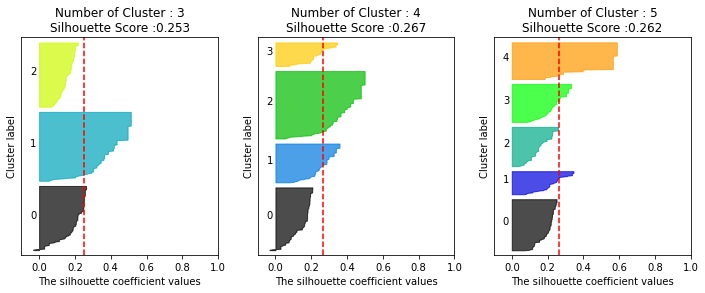

In [25]:
visualize_silhouette([3,4,5], origin_data)

### t-SNE

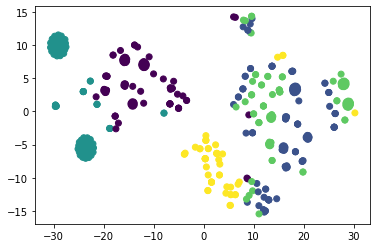

In [26]:
# t-SNE 시각화

model = TSNE(learning_rate=100)
transformed = model.fit_transform(kmeans_data.iloc[:,:20])

xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys,c=kmeans.labels_)

plt.show()

# 결과

<ul>
    <li>
        <b>cluster 0 (88) : 중립 또는 행복한 중장년층 남녀 + 비가 오는 흐린 주말 저녁</b>
        <br>남자47, 여자41 / 노년1, 중장년11, 청년76, 청소년0 / 분노2, 우울18, 중립37, 행복31
        <br>구름많음6, 맑음1, 흐림81 / 주말61, 평일27 / 저녁64, 점심24 / 비안옴1, 비87
    </li>
    <hr>
    <li>
        <b>cluster 1 (114) : 행복한 중장년 또는 청년 여자 + 맑은 평일 점심</b>
        <br>남자49, 여자65 / 노년17, 중장년42, 청년33, 청소년22 / 분노6, 우울20, 중립32, 행복52
        <br>구름많음20, 맑음92, 흐림2 / 주말0, 평일114 / 저녁0, 점심114 / 비안옴114, 비0
    </li>
    <hr>
    <li>
        <b>cluster 2 (82) : 중립 또는 행복한 청소년 남자 + 비가 오는 흐린 주말 저녁</b>
        <br>남자80, 여자2 / 노년0, 중장년7, 청년0, 청소년75 / 분노6, 우울10, 중립30, 행복36
        <br>구름많음0, 맑음0, 흐림82 / 주말80, 평일2 / 저녁80, 점심2 / 비안옴 없음, 비82
    </li>
    <br>
    <li>
        <b>cluster 3 (85) : 행복한 청년 또는 노년 여자 + 맑은 평일 저녁</b>
        <br>남자35, 여자50 / 노년28, 중장년16, 청년28, 청소년13 / 분노5, 우울16, 중립13, 행복51
        <br>구름많음5, 맑음78, 흐림2 / 주말0, 평일85 / 저녁85, 점심0 / 비안옴85, 비0
    </li>
    <hr>
    <li>
        <b>cluster4 : (52) 행복 또는 우울한 청년 남자 + 흐린 평일 점심</b>
        <br>남자36, 여자16 / 노년4, 중장년14, 청년29, 청소년5 / 분노0, 우울15, 중립10, 행복27
        <br>구름많음11, 맑음15, 흐림26 / 주말0, 평일52 / 저녁0, 점심52 / 비안옴42, 비10
    </li> 
</ul>